# Проект: Разработка решения, которое позволит персонализировать предложения постоянным клиентам для увеличения их покупательской активности.

## Введение

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе.

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

### Цель исследования


Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.

В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.

Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

### Ход исследования

Решение задачи происходит в два этапа:
1. Разработка модели, которая предскажет вероятность снижения покупательской активности.

2. Выделение сегмента покупателей, его анализ и предложение, как увеличить его покупательскую активность. Используются данные моделирования, данные о прибыли покупателей и исходные данные (при необходимости).

## Загрузка данных

In [ ]:
!pip install --upgrade scikit-learn -q

In [ ]:
!pip install phik -q

In [ ]:
!pip install shap -q

In [ ]:
#!pip install matplotlib==3.7.3

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.inspection import permutation_importance

import phik
import shap

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

- общий взгляд на данные:

In [ ]:
market_file = pd.read_csv('/datasets/market_file.csv')
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [ ]:
market_money = pd.read_csv('/datasets/market_money.csv')
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [ ]:
market_time = pd.read_csv('/datasets/market_time.csv')
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [ ]:
money = pd.read_csv('/datasets/money.csv', sep='\;', decimal=',', engine='python')
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


- Просмотр данных о рассматриваемых DataFrame:

In [ ]:
print(market_file.info())
print('-' * 100)
print(market_money.info())
print('-' * 100)
print(market_time.info())
print('-' * 100)
print(money.info())
print('-' * 100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

### Выводы

Файл с исходными данными открыт и изучен.

Данные в таблицах соответствуют описанию этих данных, однако требуется их предобработка.

## Предобработка данных

### Изменение типов данных

Не требуется

### Пропущенные значения

На предыдущем этапе с помощью метода info() было определено, что пропущенные значения отсутствуют.

### Поиск и удаление дубликатов

#### Явные дубликаты

(!) Примечание: почему-то не всегда выводит дубликаты в market_money (5 штук).

In [ ]:
print('Количество пропусков в market_file:', market_file.duplicated().sum())
print('Количество пропусков в market_money:', market_money.duplicated().sum())
print('Количество пропусков в market_time:', market_time.duplicated().sum())
print('Количество пропусков в money:', money.duplicated().sum())

Количество пропусков в market_file: 0
Количество пропусков в market_money: 0
Количество пропусков в market_time: 0
Количество пропусков в money: 0


Количество дубликатов в market_money составляет <0.5% от общего количества объектов. Удаляем дубликаты:

In [ ]:
market_money = market_money.drop_duplicates()
market_money.shape

(3900, 3)

#### Неявные дубликаты

In [ ]:
for column in market_file.columns:
    print(column, market_file[column].unique(), '\n')

id [215348 215349 215350 ... 216645 216646 216647] 

Покупательская активность ['Снизилась' 'Прежний уровень'] 

Тип сервиса ['премиум' 'стандартт' 'стандарт'] 

Разрешить сообщать ['да' 'нет'] 

Маркет_актив_6_мес [3.4 4.4 4.9 3.2 5.1 3.3 4.7 4.2 3.9 4.6 4.3 3.8 2.7 4.8 2.9 3.  2.4 1.7
 3.6 4.  1.5 3.5 4.1 3.1 1.4 0.9 5.6 2.6 5.5 5.2 5.8 5.  5.4 5.7 5.3 3.7
 6.3 6.6 4.5 6.1 5.9] 

Маркет_актив_тек_мес [5 4 3] 

Длительность [ 121  819  539  896 1064  762  431  284  192  154  450  110  623  199
  438  923  708  167  209  581  829  607  572  365  566  811  268  558
  534  730  488  436  637  554  330  504 1020  721  495  135  663 1047
  152  754  525  169  966  645  706  689  882 1007  304  339  954  771
  699  669  511  974  666  857 1048  756  506  759  768  720  219  377
  472  806  449  523  503  515  813  249  186  336  690  824  753  674
  875  844  602  855  448  344  922  298  893  881  372  788  937  764
  851 1021  627  748  684  719  891  842  573 1057  342  638  458  254
  6

In [ ]:
market_money['Период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

In [ ]:
market_time['Период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

market_file: в колонке 'Тип сервиса' обнаружен неявный дубликат;<br>
market_money: в колонке 'Период' обнаружен неявный дубликат;<br>
market_time: в колонке 'Период' обнаружена опечатка.

In [ ]:
market_file['Тип сервиса'] = market_file['Тип сервиса'].replace('стандартт', 'стандарт')
market_time['Период'] = market_time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')


Перевод наименований столбцов в змеиный регистр:

In [ ]:
market_file = market_file.rename(columns={
    'Покупательская активность': 'покупательская_активность',
    'Тип сервиса': 'тип_сервиса',
    'Разрешить сообщать': 'разрешить_сообщать'
})
market_file.columns = [c.lower() for c in market_file.columns]
market_money.columns = [c.lower() for c in market_money.columns]
market_time.columns = [c.lower() for c in market_time.columns]
money.columns = [c.lower() for c in money.columns]

### Выводы

Проведена предобработка данных:
- изменения типов данных не требуется;
- пропуски в данных не обнаружены;
- выявлены и удалены явные и неявные дубликаты.



## Исследовательский анализ данных

Описание данных:

In [ ]:
display('Описание DataFrame market_file:', market_file.describe())
display('Описание DataFrame market_money:', market_money.describe())
display('Описание DataFrame market_time:', market_time.describe())
display('Описание DataFrame money:', money.describe())

'Описание DataFrame market_file:'

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


'Описание DataFrame market_money:'

,id,выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


'Описание DataFrame market_time:'

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


'Описание DataFrame money:'

,id,прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


### Графики признаков

In [ ]:
market_file_num_cols = [
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'акционные_покупки',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит'
]

market_file_cat_cols = [
    'покупательская_активность',
    'тип_сервиса',
    'разрешить_сообщать',
    'популярная_категория',
]

Посмотрим на графики распределения категориальных признаков market_file:

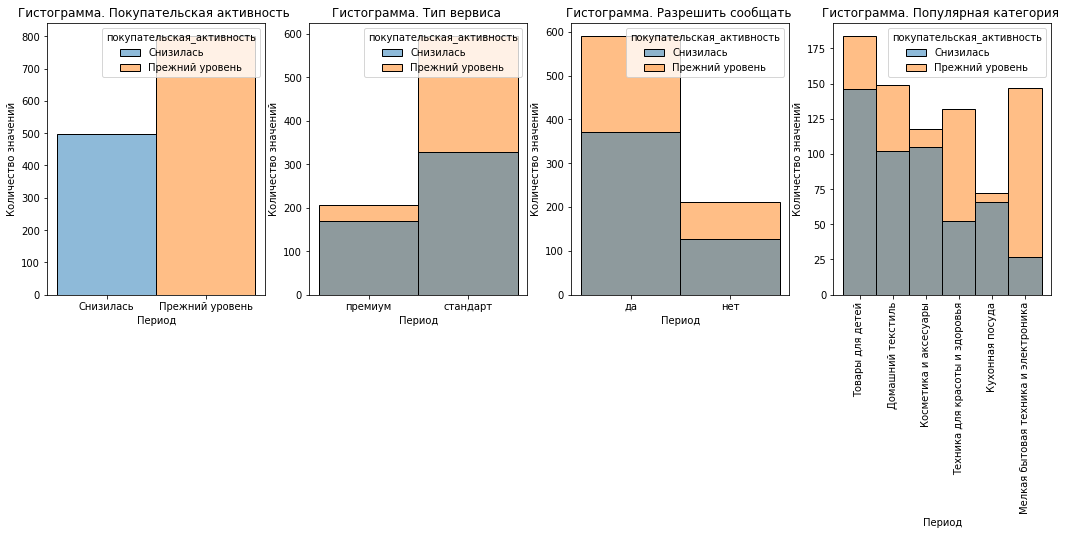

In [ ]:
fig = plt.figure(figsize=(18,5))

ax = fig.add_subplot(1, 4, 1)
g = sns.histplot(x=market_file['покупательская_активность'], bins=30, hue=market_file['покупательская_активность'])
plt.title(f'Гистограмма. Покупательская активность ')
plt.xlabel('Период')
plt.ylabel('Количество значений')

ax = fig.add_subplot(1, 4, 2)
g = sns.histplot(x=market_file['тип_сервиса'], bins=30, hue=market_file['покупательская_активность'])
plt.title(f'Гистограмма. Тип вервиса ')
plt.xlabel('Период')
plt.ylabel('Количество значений')

ax = fig.add_subplot(1, 4, 3)
g = sns.histplot(x=market_file['разрешить_сообщать'], bins=30, hue=market_file['покупательская_активность'])
plt.title(f'Гистограмма. Разрешить сообщать ')
plt.xlabel('Период')
plt.ylabel('Количество значений')

ax = fig.add_subplot(1, 4, 4)
g = sns.histplot(x=market_file['популярная_категория'], bins=30, hue=market_file['покупательская_активность'])
plt.title(f'Гистограмма. Популярная категория ')
plt.xlabel('Период')
plt.ylabel('Количество значений')
plt.xticks(rotation=90)

pass

Подтверждает информацию о том, что покупательская активность снизилась график №1 ↑: количество значений со значением покупательской активности 'Снизилась' - выше, чем 'Прежний уровень'.<br>
Сильно больше пользователей сервиса 'Премиум', чем 'обычных' пользователей - люди, готовые тратить больше денег.<br>
Сильно больше пользователей, согласных на рассылку о доп. предложениях о товаре - потенциально более лояльные.<br>
Самая популярная категория товаров у покупателя за последние 6 месяцев - 'Товары для детей'.

Распределение признака 'Период' (название периода, во время которого зафиксирована выручка) в market_money с учетом целевого признака:

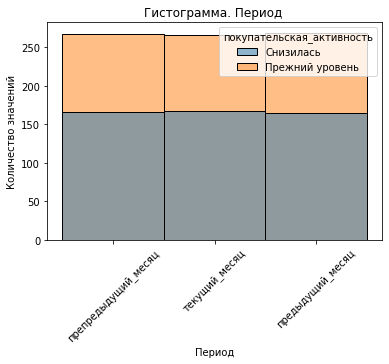

In [ ]:
sns.histplot(x=market_money['период'], bins=30, hue=market_file['покупательская_активность'])
plt.title(f'Гистограмма. Период ')
plt.xlabel('Период')
plt.ylabel('Количество значений')
plt.xticks(rotation=45)

pass

Да и общая выручка в предыдущем месяце сильно выше (почти в 2 раза):

In [ ]:
market_money.groupby('период')['выручка'].agg('sum')

период
предыдущий_месяц       6417996.5
препредыдущий_месяц    6272769.0
текущий_месяц          6909449.1
Name: выручка, dtype: float64

В текущий месяц значений примерно в 2 раза меньше.

Распределение признака 'Период' (название периода,  во время которого зафиксировано общее время) в market_time с учетом целевого признака:

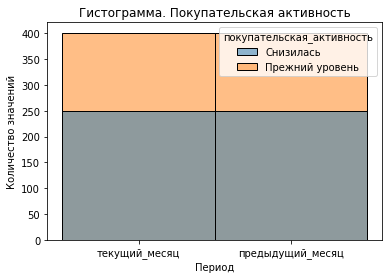

In [ ]:
sns.histplot(x=market_time['период'], bins=30, hue=market_file['покупательская_активность'])
plt.title(f'Гистограмма. Покупательская активность')
plt.xlabel('Период')
plt.ylabel('Количество значений')
pass

Периоды поделены поровну. Количество минут, проведенных на сайте тоже почти совпадает:

In [ ]:
market_time.groupby('период')['минут'].agg('sum')

период
предыдущий_месяц    17508
текущий_месяц       17166
Name: минут, dtype: int64

Построим графики для количественных признаков (гистограммы и boxplot'ы) с учетом целевого признака.

Сначала для DataFrame **market_file**:

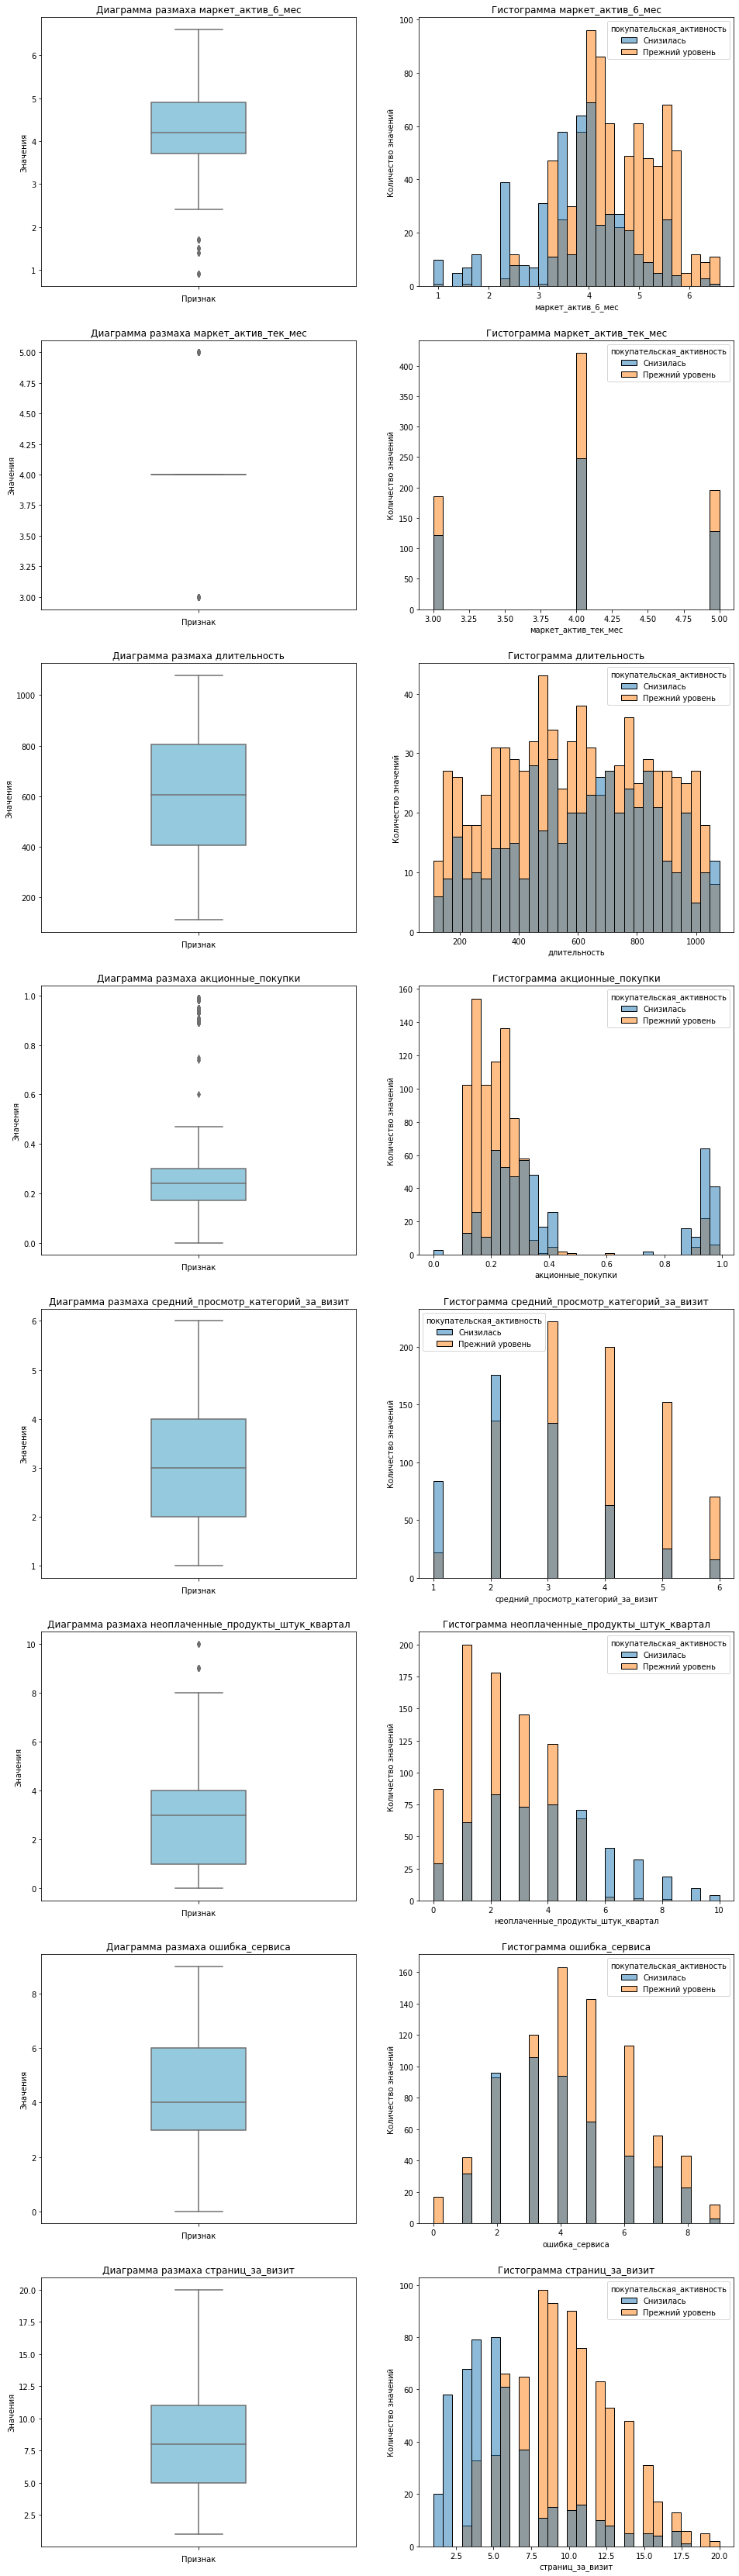

In [ ]:
fig = plt.figure(figsize=(16,60))

total_axes = len(market_file_num_cols)
subplt = 1
for n, c in enumerate(market_file[market_file_num_cols]):
    ax = fig.add_subplot(total_axes, 2, subplt)
    sns.boxplot(y=market_file[c], color='skyblue', width=.3, hue=market_file['покупательская_активность'])
    subplt += 1
    plt.title(f'Диаграмма размаха {c}')
    plt.xlabel('Признак')
    plt.ylabel('Значения')
    ax = fig.add_subplot(total_axes, 2, subplt)
    sns.histplot(x=market_file[c], color='skyblue', bins=30, hue=market_file['покупательская_активность'])
    subplt += 1
    plt.title(f'Гистограмма {c}')
    plt.xlabel(market_file_num_cols[n])
    plt.ylabel('Количество значений')
pass

Имеются выбросы в данных.<br>
Самое странное распределение данных - признак 'акционные_покупки'.

In [ ]:
print('Количество выбросов в признаке маркет_актив_6_мес:', \
      '{:.1%}'.format(market_file.query('маркет_актив_6_мес < 2.5').shape[0] / market_file.shape[0]))
print('Количество выбросов в признаке маркет_актив_тек_мес:', \
      '{:.1%}'.format(market_file.query('маркет_актив_тек_мес < 3.05 or маркет_актив_тек_мес > 4.85').shape[0] / market_file.shape[0]))
print('Количество выбросов в признаке акционные_покупки:', \
      '{:.1%}'.format(market_file.query('акционные_покупки > 0.55').shape[0] / market_file.shape[0]))
print('Количество выбросов в признаке неоплаченные_продукты_штук_квартал:', \
      '{:.1%}'.format(market_file.query('неоплаченные_продукты_штук_квартал > 8').shape[0] / market_file.shape[0]))

Количество выбросов в признаке маркет_актив_6_мес: 6.0%
Количество выбросов в признаке маркет_актив_тек_мес: 48.5%
Количество выбросов в признаке акционные_покупки: 12.9%
Количество выбросов в признаке неоплаченные_продукты_штук_квартал: 1.1%


DataFrame market_file - небольшой. Пока оставим выбросы.<br>
Также отметим, что удаление выбросов  в признаке 'акционные_покупки' сделало бы распределение данных на гистограмме ближе к нормальному.

Распределение признака 'выручка' DataFrame **market_money**:

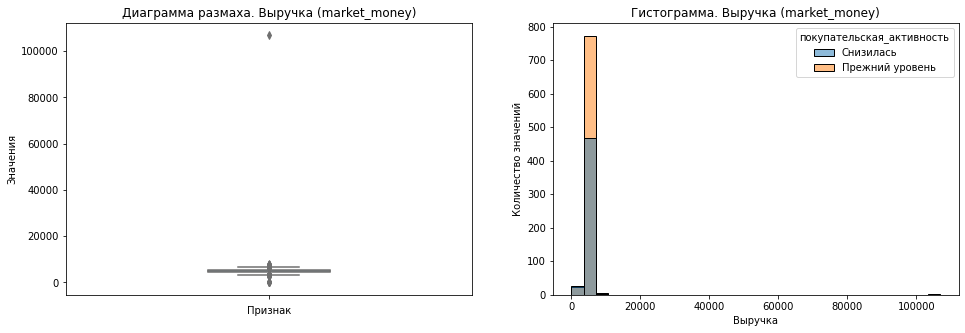

In [ ]:
fig = plt.figure(figsize=(16,5))


ax = fig.add_subplot(1, 2, 1)
sns.boxplot(y=market_money['выручка'], color='skyblue', width=.3, hue=market_file['покупательская_активность'])
plt.title(f'Диаграмма размаха. Выручка (market_money)')
plt.xlabel('Признак')
plt.ylabel('Значения')

ax = fig.add_subplot(1, 2, 2)
sns.histplot(x=market_money['выручка'], color='skyblue', bins=30, hue=market_file['покупательская_активность'])

plt.title(f'Гистограмма. Выручка (market_money)')
plt.xlabel('Выручка')
plt.ylabel('Количество значений')
pass

Посмотрим на аномальное значение в выручке, а также, сколько еще выручки приносил клиент с этим id:

In [ ]:
market_money.query('выручка > 100000')

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [ ]:
market_money[market_money['id'] == 215380]

,id,период,выручка
96,215380,препредыдущий_месяц,5051.0
97,215380,предыдущий_месяц,6077.0
98,215380,текущий_месяц,106862.2


Столь высокое значение выручки не характерно для данного id. Возможно, тех. ошибка. Оставим данный объект, разделив значение выручки на 10, чтобы число было реальнее:

In [ ]:
market_money.loc[98, 'выручка'] = market_money.loc[98, 'выручка'] / 10
market_money.loc[98, 'выручка']

10686.22

Посмотрим на графики еще раз:

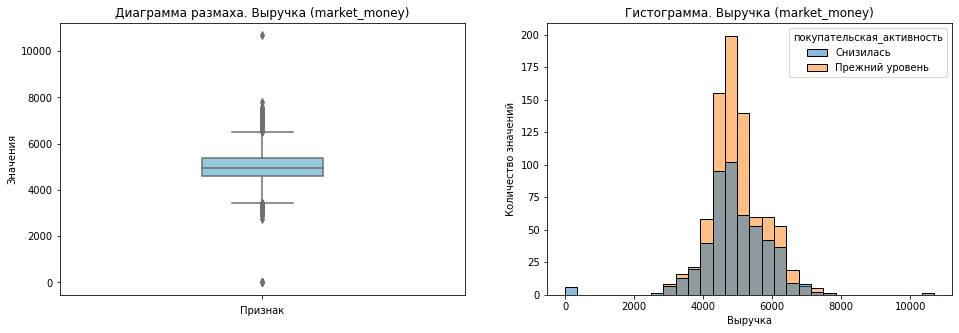

In [ ]:
fig = plt.figure(figsize=(16,5))


ax = fig.add_subplot(1, 2, 1)
sns.boxplot(y=market_money['выручка'], color='skyblue', width=.3, hue=market_file['покупательская_активность'])
plt.title(f'Диаграмма размаха. Выручка (market_money)')
plt.xlabel('Признак')
plt.ylabel('Значения')

ax = fig.add_subplot(1, 2, 2)
sns.histplot(x=market_money['выручка'], color='skyblue', bins=30, hue=market_file['покупательская_активность'])

plt.title(f'Гистограмма. Выручка (market_money)')
plt.xlabel('Выручка')
plt.ylabel('Количество значений')
pass

In [ ]:
print('Количество выбросов в признаке выручка:', \
      '{:.1%}'.format(market_money.query('3500 > выручка or выручка > 6500').shape[0] / market_money.shape[0]))

Количество выбросов в признаке выручка: 4.8%


Распределение выручки по периодам:

Text(0, 0.5, 'Значения')

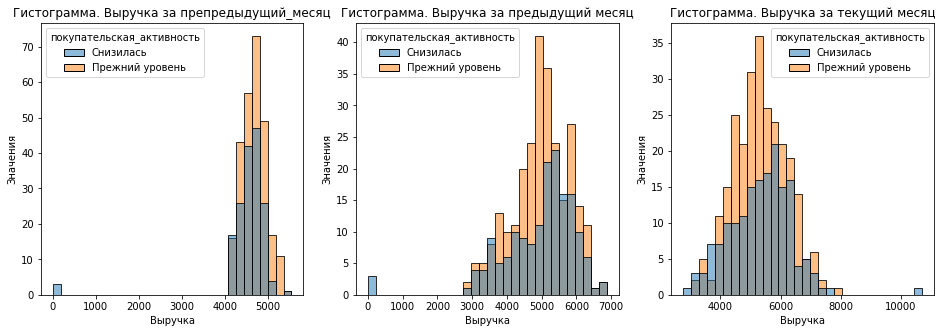

In [ ]:
fig = plt.figure(figsize=(16,5))


ax = fig.add_subplot(1, 3, 1)
sns.histplot(x=market_money.query('период == "препредыдущий_месяц"')['выручка'], color='skyblue', bins=30, hue=market_file['покупательская_активность'])
plt.title(f'Гистограмма. Выручка за препредыдущий_месяц')
plt.xlabel('Выручка')
plt.ylabel('Значения')

ax = fig.add_subplot(1, 3, 2)
sns.histplot(x=market_money.query('период == "предыдущий_месяц"')['выручка'], color='skyblue', bins=30, hue=market_file['покупательская_активность'])
plt.title(f'Гистограмма. Выручка за предыдущий месяц')
plt.xlabel('Выручка')
plt.ylabel('Значения')

ax = fig.add_subplot(1, 3, 3)
sns.histplot(x=market_money.query('период == "текущий_месяц"')['выручка'], color='skyblue', bins=30, hue=market_file['покупательская_активность'])
plt.title(f'Гистограмма. Выручка за текущий месяц')
plt.xlabel('Выручка')
plt.ylabel('Значения')

Распределение признака 'минут' (значение времени, проведённого на сайте, в минутах) DataFrame **market_time**:

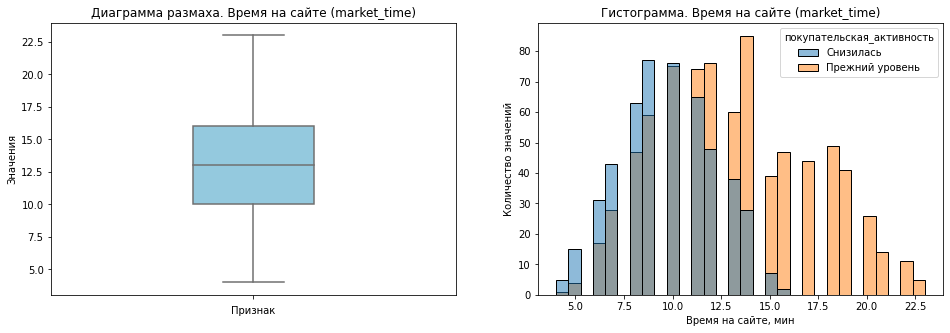

In [ ]:
fig = plt.figure(figsize=(16,5))


ax = fig.add_subplot(1, 2, 1)
sns.boxplot(y=market_time['минут'], color='skyblue', width=.3, hue=market_file['покупательская_активность'])
plt.title(f'Диаграмма размаха. Время на сайте (market_time)')
plt.xlabel('Признак')
plt.ylabel('Значения')

ax = fig.add_subplot(1, 2, 2)
sns.histplot(x=market_time['минут'], color='skyblue',bins=30, hue=market_file['покупательская_активность'])

plt.title(f'Гистограмма. Время на сайте (market_time)')
plt.xlabel('Время на сайте, мин')
plt.ylabel('Количество значений')
pass

Распределение времени по периодам:

Text(0, 0.5, 'Значения')

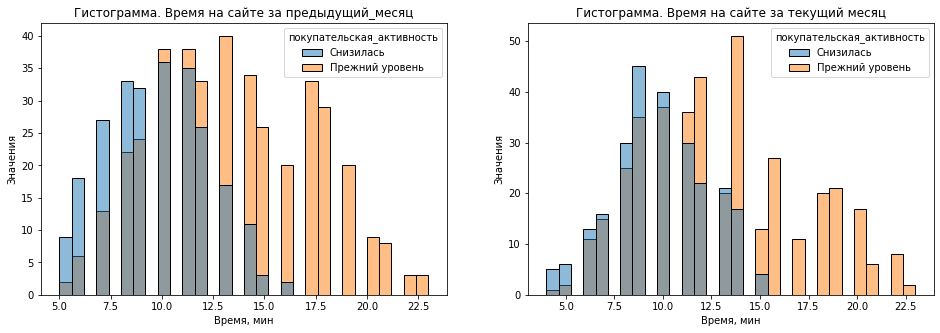

In [ ]:
fig = plt.figure(figsize=(16,5))


ax = fig.add_subplot(1, 2, 1)
sns.histplot(x=market_time.query('период == "предыдущий_месяц"')['минут'], color='skyblue', bins=30, hue=market_file['покупательская_активность'])
plt.title(f'Гистограмма. Время на сайте за предыдущий_месяц')
plt.xlabel('Время, мин')
plt.ylabel('Значения')

ax = fig.add_subplot(1, 2, 2)
sns.histplot(x=market_time.query('период == "текущий_месяц"')['минут'], color='skyblue', bins=30, hue=market_file['покупательская_активность'])
plt.title(f'Гистограмма. Время на сайте за текущий месяц')
plt.xlabel('Время, мин')
plt.ylabel('Значения')

Распределение признака 'прибыль' DataFrame **money** с учетом целевого признака:

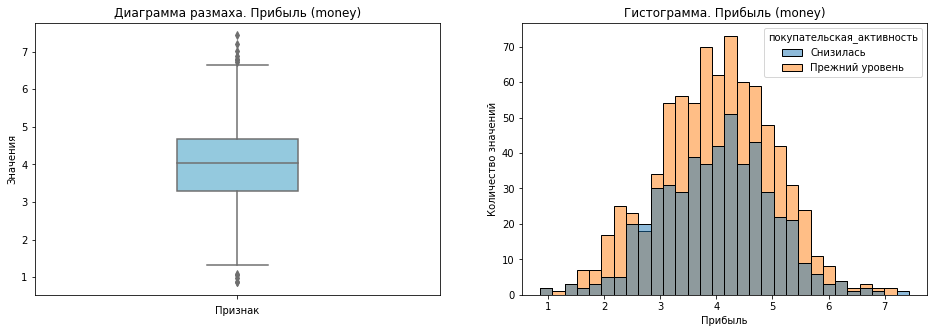

In [ ]:
fig = plt.figure(figsize=(16,5))


ax = fig.add_subplot(1, 2, 1)
sns.boxplot(y=money['прибыль'], color='skyblue', width=.3, hue=market_file['покупательская_активность'])
plt.title(f'Диаграмма размаха. Прибыль (money)')
plt.xlabel('Признак')
plt.ylabel('Значения')

ax = fig.add_subplot(1, 2, 2)
sns.histplot(x=money['прибыль'], color='skyblue', bins=30, hue=market_file['покупательская_активность'])

plt.title(f'Гистограмма. Прибыль (money)')
plt.xlabel('Прибыль')
plt.ylabel('Количество значений')
pass

In [ ]:
print('Количество выбросов в признаке выручка:', \
      '{:.1%}'.format(money.query('1.5 > прибыль or прибыль > 6.5').shape[0] / money.shape[0]))

Количество выбросов в признаке выручка: 1.8%


**Отбор клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период:**

В Таблице 'money' хранятся данные о среднемесячной прибыли покупателя *за последние 3 месяца*: какую прибыль получает магазин от продаж каждому покупателю. У каждого id ненулевое значение прибыли:

In [ ]:
money.query('прибыль == 0').count()


id         0
прибыль    0
dtype: int64

### Выводы

На данном этапе было выявлено, что:

- покупательская активность снизилась: количество значений со значением покупательской активности 'Снизилась' - выше, чем 'Прежний уровень'.<br>
- сильно больше пользователей сервиса 'Премиум', чем 'обычных' пользователей - люди, готовые тратить больше денег.<br>
- сильно больше пользователей, согласных на рассылку о доп. предложениях о товаре - потенциально более лояльные.<br>
- самая популярная категория товаров у покупателя за последние 6 месяцев - 'Товары для детей';
- общая выручка в прошлом месяце была почти в 2 раза больше месяца текущего;
- количество проведенного времени на сайте почти одинаково в текущем месяце и месяце предыдущем.

Дааграммы размаха показали, что у некоторых признаков есть выбросы, которые пока не удалены ввиду небольшого размера Датасетов.  Аномальное значение  в признаке 'выручка' (DataFrame market_money) было скорректировано.

## Объединение таблиц

Объединим таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании не понадобятся.

In [ ]:
market_file_all = market_file.merge(
    market_money.pivot_table(index='id', values='выручка', columns='период').reset_index(), on='id'
) \
    .merge(
    market_time.pivot_table(index='id', values='минут', columns='период').reset_index(), on='id'
) \
    .rename(
    columns={'предыдущий_месяц_x': 'выручка_пред_мес',
            'текущий_месяц_x': 'выручка_тек_мес',
             'предыдущий_месяц_y': 'минут_пред_мес',
             'текущий_месяц_y': 'минут_тек_мес'
            }
)
print(market_file_all.shape)
market_file_all.head()

(1300, 18)


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред_мес,препредыдущий_месяц,выручка_тек_мес,минут_пред_мес,минут_тек_мес
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [ ]:
market_file_all.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_пред_мес                       0
препредыдущий_месяц                    0
выручка_тек_мес                        0
минут_пред_мес                         0
минут_тек_мес                          0
dtype: int64

Выберем клиентов, которые проявляли активность в последние 3 месяца:

In [ ]:
market_file_all = market_file_all.query('выручка_пред_мес > 0 and препредыдущий_месяц > 0 and выручка_тек_мес > 0')
market_file_all.shape

(1297, 18)

### Выводы

Таблицы market_file.csv, market_money.csv, market_time.csv объединены для дальнейшей работы.
Учитено, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделаны отдельные столбцы для каждого периода.

## Корреляционный анализ

### Матрицы корреляций

Построим общую матрицу корреляций признаков объединенного датафрейма. Т.к. в наличии имеются признаки, которые распределены ненормально, выберем коэффициент ранговой корреляции Спирмена:

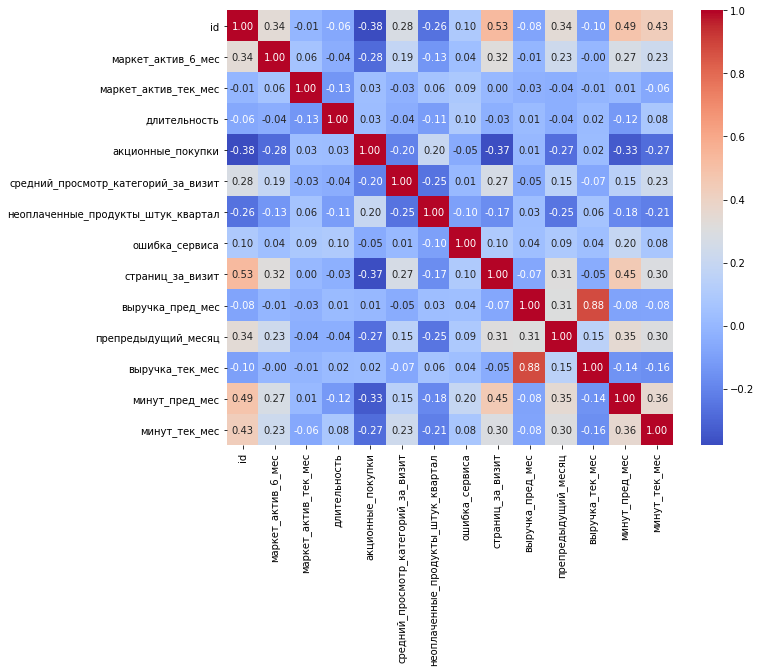

In [ ]:
fig = plt.figure(figsize=(10, 8))

sns.heatmap(market_file_all.corr(method='spearman'), cmap='coolwarm', annot=True, fmt='.2f')
pass

Построим матрицу корреляций, которая учитывает категориальные признаки (коэффициент корреляции Фи):

interval columns not set, guessing: ['id', 'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки', 'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 'страниц_за_визит', 'выручка_пред_мес', 'препредыдущий_месяц', 'выручка_тек_мес', 'минут_пред_мес', 'минут_тек_мес']


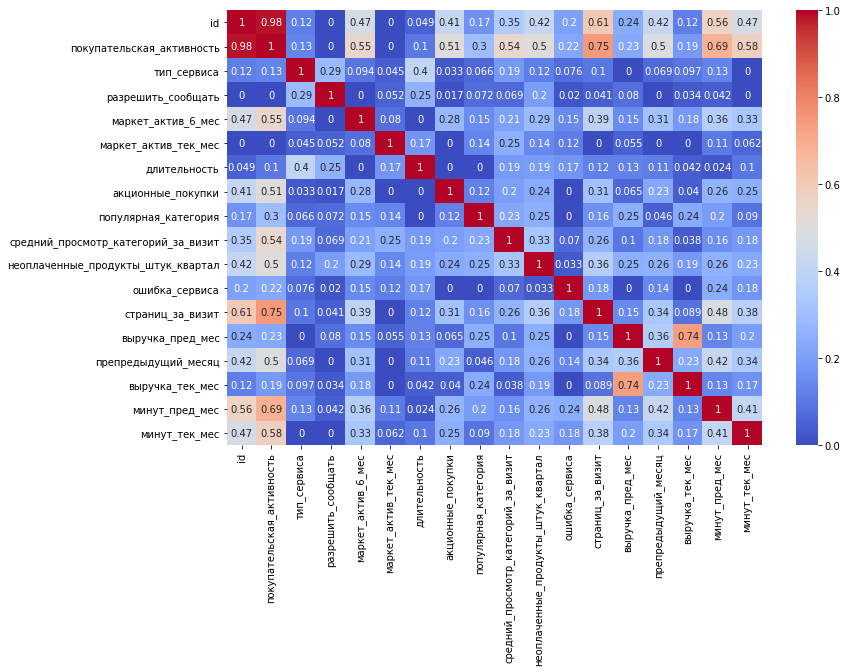

In [ ]:
fig = plt.figure(figsize=(12, 8))

sns.heatmap(
    market_file_all.phik_matrix(),
    cmap='coolwarm',
    annot=True,
    fmt='.2g'
)
pass

Дополнительно построим матрицы корреляций признаков с разделением значений целевого признака :

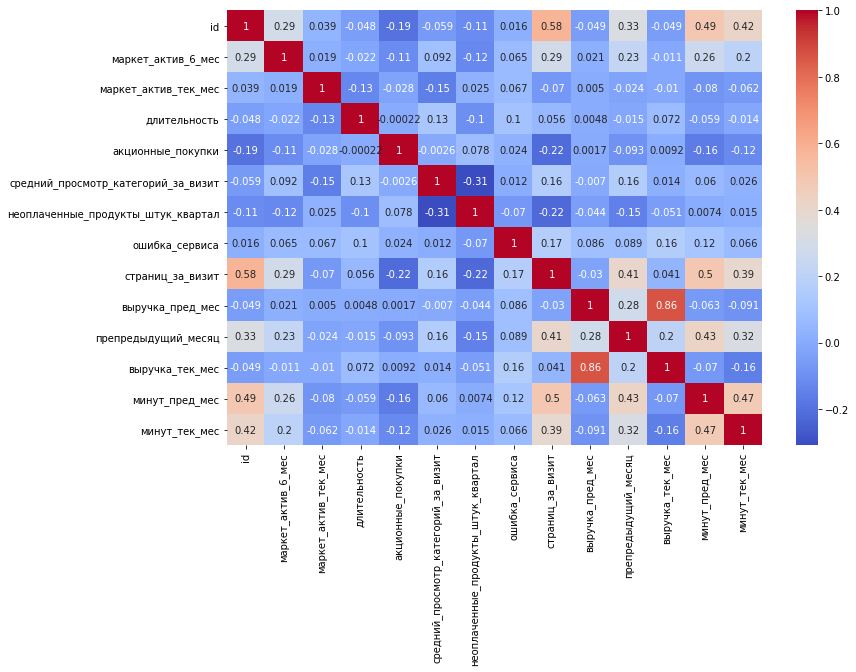

In [ ]:
fig = plt.figure(figsize=(12, 8))

sns.heatmap(
    market_file_all.query('покупательская_активность == "Снизилась"').corr(),
    cmap='coolwarm',
    annot=True,
    fmt='.2g'
)
pass

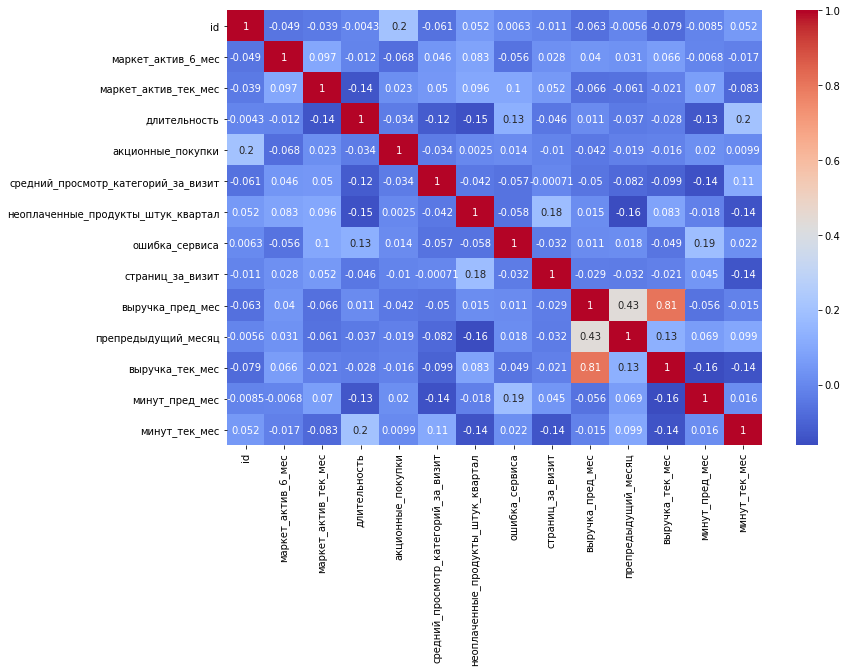

In [ ]:
fig = plt.figure(figsize=(12, 8))

sns.heatmap(
    market_file_all.query('покупательская_активность == "Прежний уровень"').corr(),
    cmap='coolwarm',
    annot=True,
    fmt='.2g'
)
pass

Для покупательской активности со значением 'Прежний уровень' связь между признаками выражена слабее.


Как правило, о мультиколлинеарности говорят при значении коэффициента корреляции от 0.9 до 0.95 по модулю.  В настоящем датасете такие коэффициенты отсутствуют.

Дополнительное исследование на мультиколлинеарность с помощью VIF (Variance Inflation Factor):

In [ ]:
# Используем покупательская_активность в качестве целевой переменной
y, X = dmatrices('покупательская_активность ~ маркет_актив_6_мес+маркет_актив_тек_мес+длительность+ \
    акционные_покупки+средний_просмотр_категорий_за_визит+неоплаченные_продукты_штук_квартал+ошибка_сервиса+ \
    страниц_за_визит+выручка_пред_мес+выручка_тек_мес+минут_пред_мес+минут_пред_мес+тип_сервиса+разрешить_сообщать+ \
    популярная_категория', \
    data=market_file_all, return_type='dataframe')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

vif

,VIF,variable
0,169.872603,Intercept
1,1.179776,тип_сервиса[T.стандарт]
2,1.110787,разрешить_сообщать[T.нет]
3,1.685696,популярная_категория[T.Косметика и аксесуары]
4,1.473699,популярная_категория[T.Кухонная посуда]
5,1.544682,популярная_категория[T.Мелкая бытовая техника ...
6,1.583132,популярная_категория[T.Техника для красоты и з...
7,1.839684,популярная_категория[T.Товары для детей]
8,1.211894,маркет_актив_6_мес
9,1.069436,маркет_актив_тек_мес


Значения >5 указывают на мультиколлинеарность между независимыми переменными. В данном случае значения находятся в пределах 1.1-1.9,  что означает умеренную зависимость между признаками, что допустимо. <br>
Значение Intersept игнорируем, он не имеет значения для модели.

Дополнительно взглянем на диаграммы рассеяния признаков:

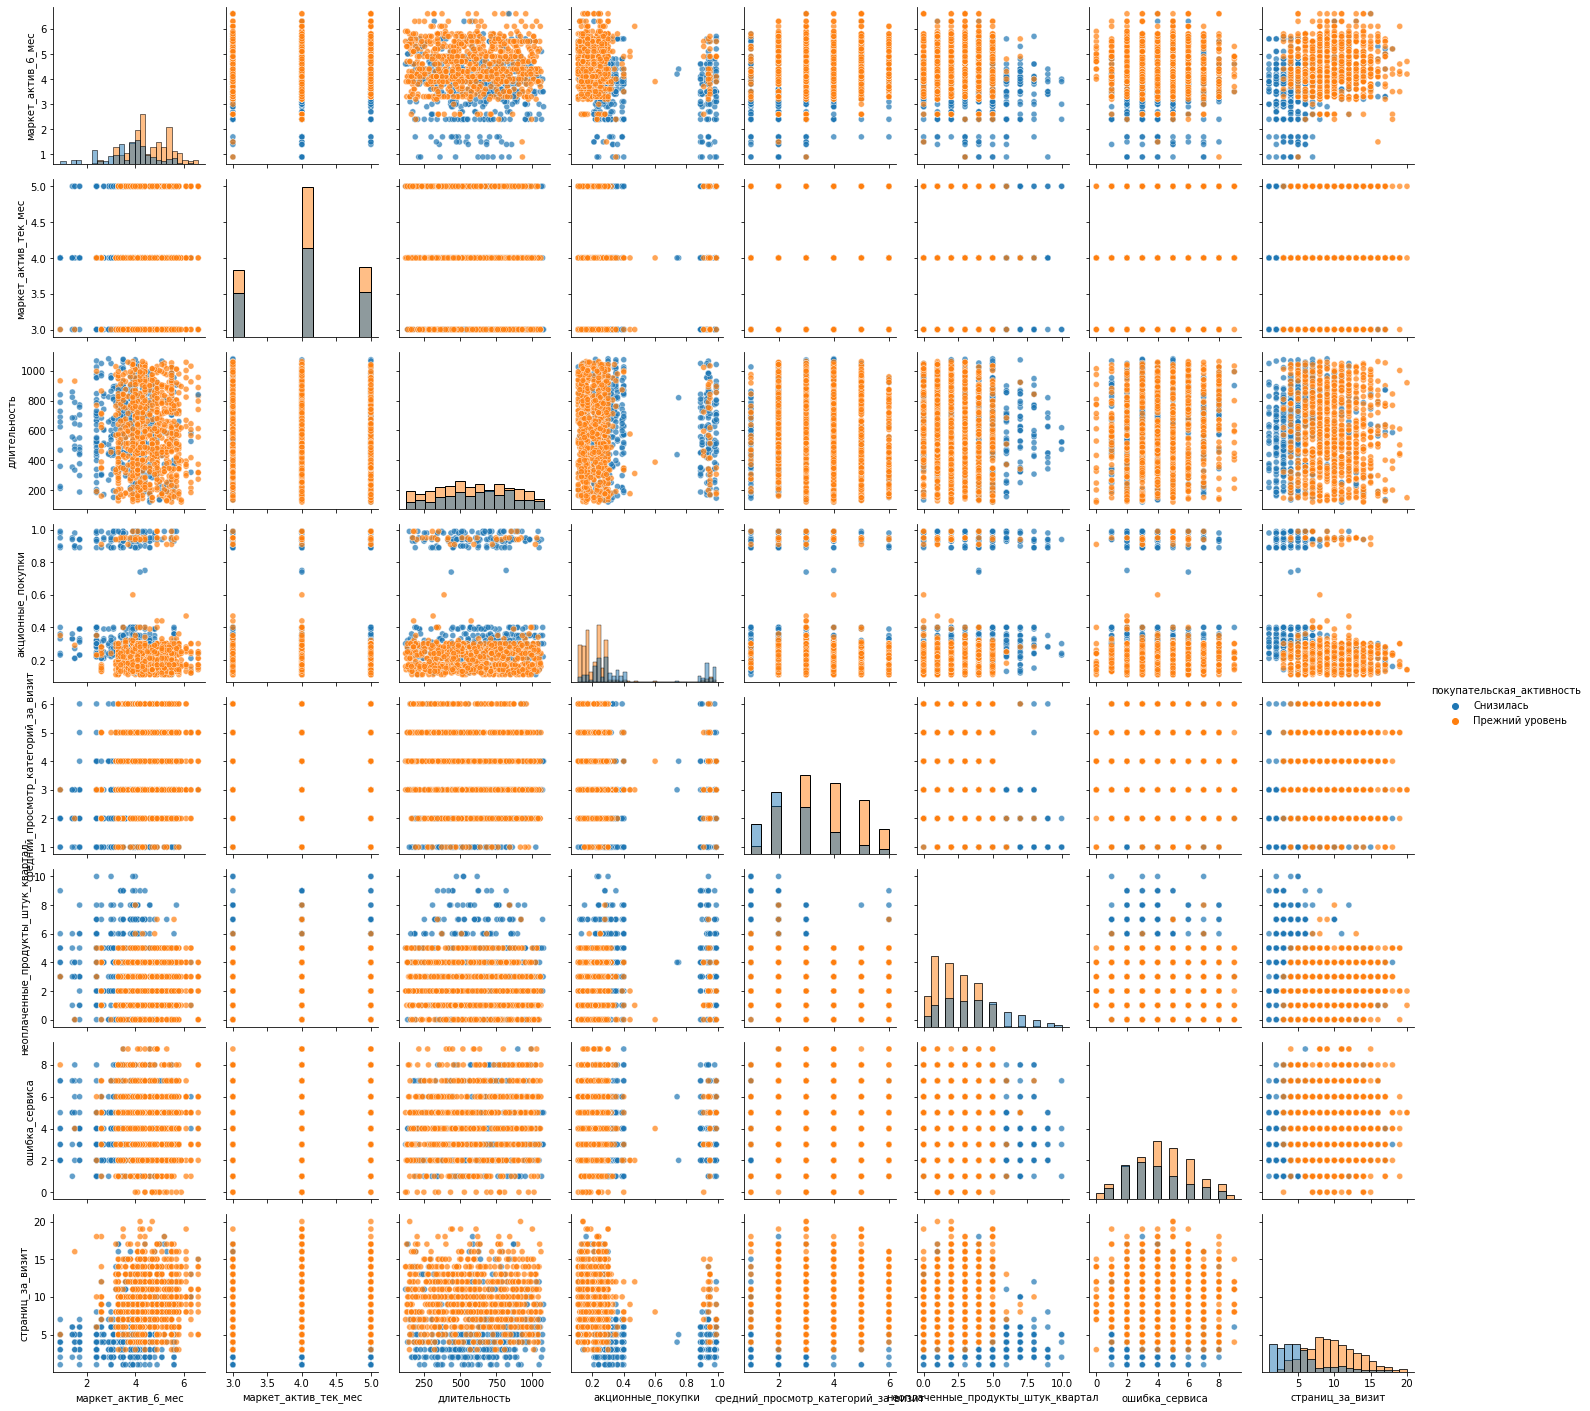

In [ ]:
g = sns.PairGrid(market_file_all, vars=market_file_num_cols, hue='покупательская_активность')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot, alpha=0.7)
g.add_legend()
pass

Значения целевого признака  часто перемешаны между собой, что затрудняет классификацию. Однако, есть и более выраженные границы.

Зависимость между id и акционными покупками:

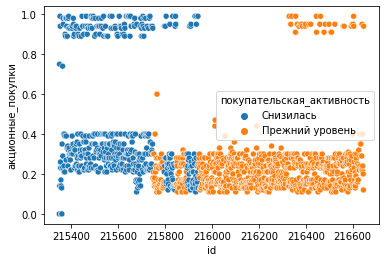

In [ ]:
sns.scatterplot(data=market_file, x='id', y='акционные_покупки', hue='покупательская_активность')
pass

На основаниее графика выше можно сделать вывод о том, что более старые id (пользователи, зарегистрированные раньше) - стали менее лояльными, их активность снизилась.

### Выводы

В данном разделе был проведен корреляционный анализ  признаков.

Матрица корреляций с использованием коэффициента ранговой корреляции Спирмена и матрица корреляций с использованием коэффициента корреляции Фи не выявили мультиколлинеарности между признаками.

Также был проведен дополнительный анализ на наличие мультиколлинеарности (VIF): мультиколлинеарность не обнаружена.

## Использование пайплайнов

### Подготовка данных

In [ ]:
market_file_all = market_file_all.reset_index().set_index('id')
market_file_all.head()

,index,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред_мес,препредыдущий_месяц,выручка_тек_мес,минут_пред_мес,минут_тек_мес
id,,,,,,,,,,,,,,,,,,
215349,1,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
215350,2,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
215351,3,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
215352,4,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
215353,5,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    market_file_all.drop(['покупательская_активность'], axis=1),
    market_file_all['покупательская_активность'],
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = market_file_all['покупательская_активность'])

X_train.shape, X_test.shape

((972, 17), (325, 17))

In [ ]:
# создаём списки с названиями признаков
ohe_columns = ['разрешить_сообщать', 'популярная_категория']
# Т.к. у нас нет ранговых переменных, а также потому, что в случае кодирования OrdinalEncoder'ом неранговых признаков
# линейные модели могут некорректно понять такие кодировки
ord_columns = ['тип_сервиса']
num_columns = [
    'маркет_актив_6_мес',
    'маркет_актив_тек_мес',
    'длительность',
    'акционные_покупки',
    'средний_просмотр_категорий_за_визит',
    'неоплаченные_продукты_штук_квартал',
    'ошибка_сервиса',
    'страниц_за_визит',
    'выручка_пред_мес',
    'выручка_тек_мес',
    'минут_тек_мес',
    'минут_пред_мес'
    ]

In [ ]:
# кодируем целевой признак
label_encoder = LabelEncoder()

label_encoder.fit(y_train)
y_train_le = label_encoder.transform(y_train)
y_test_le = label_encoder.transform(y_test)

In [ ]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# Не сразу понял, что в обновленном sci-kit learn 'sparse' называется иначе...
ohe_pipe = Pipeline(
    [
     ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False))
    ]
)

In [ ]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары', \
                     'Техника для красоты и здоровья', 'Кухонная посуда', 'Мелкая бытовая техника и электроника']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [ ]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ],
    #remainder='passthrough'
)

In [ ]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline(
    [
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

In [ ]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,15),
        'models__max_features': range(2,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(3,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': [1, 2, 5, 10, 20, 50, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['poly', 'linear', 'rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

**Выбор подходящей метрики:**

Выбираем метрику ROC-AUC, т.к. она используется, когда необходимо оценить качество работы модели вне зависимости от выбранного порога вероятности; ее можно использовать в случае, когда объектов с одним значением целевого признака больше, чем с другими. Наш случай.

In [ ]:
%%time

randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train_le)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', randomized_search.best_score_)

# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_test_pred = randomized_search.predict_proba(X_test)
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}', '\n')

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/imput

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['разрешить_сообщать',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/imput

Проверка модели на адекватность:

In [ ]:
X_train_for_dummy = pd.DataFrame(data_preprocessor.fit_transform(X_train))
X_test_for_dummy = pd.DataFrame(data_preprocessor.transform(X_test))

# создание и обучение модели DummyClassifier
dummy_model = DummyClassifier(random_state=RANDOM_STATE)
dummy_model.fit(X_train_for_dummy, y_train)

dummy_model_proba = dummy_model.predict_proba(X_test_for_dummy)
#dummy_model_preds = dummy_model.predict(X_test_for_dummy)

dummy_acc = roc_auc_score(y_test, dummy_model_proba[:,1])
print('ROC-AUC =', round(dummy_acc, 2))

'''dummy_acc = accuracy_score(y_test, dummy_model_preds)
print('Dummy Accuracy =', round(dummy_acc,2))'''
pass

ROC-AUC = 0.5


/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


Как-то слабо.. Вероятно из-за того, что датасет несбалансирован, модель недообучилась? ↑

### Выводы

Были подготовлены пайплайны для автоматизации подбора подходящих моделей и гиперпараметров.
Проанализировано 4 модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), SVC() с перебором гиперпараметров.

Лучше других себя показала модель DecisionTreeClassifier(max_depth=4, max_features=3, random_state=42), метрика ROC-AUC на тренировочной и тестовой выборках показала себя хорошо.

## Анализ важности признаков

Оцениим важность признаков для лучшей модели и построим график важности с помощью метода SHAP:

In [ ]:
# вывод лучшей модели
the_best_model = randomized_search.best_estimator_['models']
the_best_model

DecisionTreeClassifier(max_depth=4, max_features=3, random_state=42)

In [ ]:
# предобработка данных и вывод имен новых признаков после кодирования ohe. Создание DataFrame
X_train_prepr = pd.DataFrame(
    randomized_search.best_estimator_['preprocessor'].fit_transform(X_train),
    columns=randomized_search.best_estimator_['preprocessor'].get_feature_names_out()
)

X_test_prepr = pd.DataFrame(
    randomized_search.best_estimator_['preprocessor'].transform(X_test),
    columns=randomized_search.best_estimator_['preprocessor'].get_feature_names_out()
)

/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/impute/_base.py:598: UserWarning: Skipping features without any observed values: [0]. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


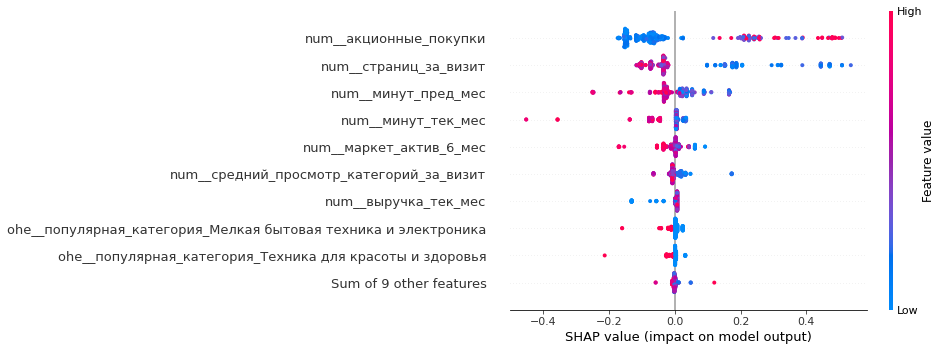

In [ ]:
# используем Explainer. Во избежание ошибки размерности массива используем shap_values[...,0]
explainer = shap.Explainer(the_best_model)
shap_values = explainer(X_test_prepr)
#explainer.feature_names = randomized_search.best_estimator_['preprocessor'].get_feature_names_out()
shap_values
shap.plots.beeswarm(shap_values[...,1])

График beeswarm показывает наиболее важные признаки текущей модели:
- количество минут, проведенных на сайте в текущем месяце;
- просмотренных страниц за визит;
- средний просмотр категорий за визит в течение последнего месяца.

Также график показывает, что:
- негативные значения Шепли слева от центральной вертикальной линии означают, что признак склоняет модель отнести объекты к классу 0, а положительные справа — к классу 1;
- более высокое (более красное) значение признака 'минут в текущем месяце' снижает SHAP-значения, т.е. более высокое значение этого признака увеличивает вероятность отнесения к классу 0 (покупательская активность не изменилась). Тоже самое относится и к двум следующим признакам;
- при этом бОльшие значения акционных покупок ведут к классу 1 (покупательская активность снизилась).

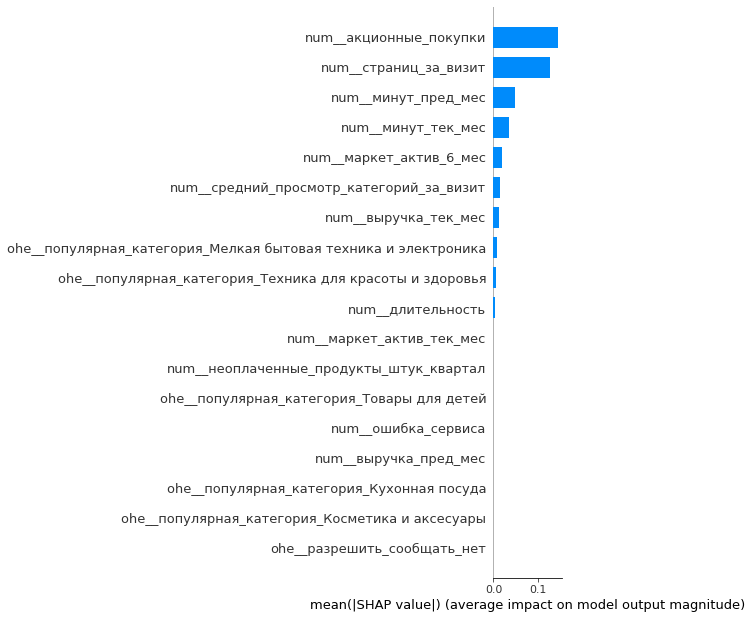

In [ ]:
shap.summary_plot(shap_values[...,0], plot_type='bar', max_display=20)

График общей значимости признаков также показывает нам наиболее значимые признаки, как и beeswarm, описанный выше.

Значимость признаков также рассмотрим с помощью Permutation Importance:

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without featu

<AxesSubplot:ylabel='Feature'>

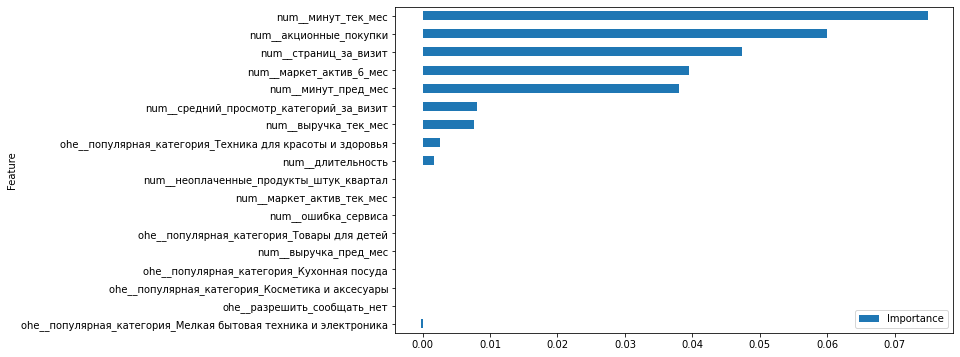

In [ ]:
permutation = permutation_importance(the_best_model, X_test_prepr, y_test, scoring='roc_auc')

#X_test_prepr.columns[selector.get_support(indices=True)]
feature_importance = pd.DataFrame({'Feature': X_test_prepr.columns, 'Importance': permutation['importances_mean']})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))

В случае с Permutation Importance тройка лидеров среди признаков одна и та же, однако изменился порядок первого и второго места.

### Выводы

**Значимость признаков:**

Согласно выявленным значениям Шепли, наиобольшее значение на целевой признак имеют следующие входные признаки: <br>
- количество минут, проведенных на сайте в текущем месяце;
- просмотренных страниц за визит;
- средний просмотр категорий за визит в течение последнего месяца.

Наименее значимы признаки, рсположившиеся внизу графика shap.summary_plot.
<br><br>

**Использование полученной информации при принятии бизнес-решений:**

Лицам, принимающим решения, стоит уделить внимание поведению пользователей на сайте (количество минут, проведенное на сайте; просмотренных страниц за визит) и продуктовое поведение (средний просмотр категорий за визит): увеличение этих показателей положительно влияет на лояльность покупателей.<br>


## Сегментация покупателей

### Вариант 1

Выполним сегментацию покупателей:

In [ ]:
pd.DataFrame(y_train_le, y_train,columns=['LabelEncoder']).head(3)

,LabelEncoder
покупательская_активность,
Прежний уровень,0
Снизилась,1
Прежний уровень,0


In [ ]:
# добавим колонку предсказаний, реальных значений из y_test (1 - покупательская активность снизилась, 0 - не изменилась)
preds = the_best_model.predict_proba(X_test_prepr)[:, 1]

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [ ]:
# вернем id
X_test_prepr['id'] = X_test.reset_index()['id']

In [ ]:
# сегментация
segmentation = market_file_all.merge(X_test_prepr['id'], on='id', how='right')
segmentation['predictions'] = preds
# добавим прибыль
segmentation = segmentation.set_index('id')
segmentation = segmentation.merge(money, on='id')
segmentation.head()

,id,index,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,...,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред_мес,препредыдущий_месяц,выручка_тек_мес,минут_пред_мес,минут_тек_мес,predictions,прибыль
0,216446,1098,Прежний уровень,стандарт,да,5.3,5,433,0.91,Техника для красоты и здоровья,...,1,0,7,4712.0,5160.0,5230.7,15,20,0.000000,4.47
1,215469,121,Снизилась,премиум,да,4.1,3,813,0.22,Домашний текстиль,...,3,4,5,5403.5,4889.0,5228.0,12,8,0.945205,3.76
2,216301,953,Прежний уровень,премиум,да,3.9,5,410,0.20,Косметика и аксесуары,...,1,5,14,5052.5,5348.0,4926.4,17,13,0.170732,4.34
3,215713,365,Снизилась,стандарт,да,4.6,5,293,0.24,Товары для детей,...,3,3,3,4821.0,4872.0,5221.4,12,14,0.945205,4.42
4,215500,152,Снизилась,стандарт,да,3.5,4,573,0.40,Косметика и аксесуары,...,4,1,4,4137.0,4278.0,3808.1,11,12,0.881890,4.99



Выберем группу покупателей, у которых высокая вероятность снижения покупательской активности, и посмотрим на распределение наиболее значимых признаков:

In [ ]:
segmentation_class_1 = segmentation.query('predictions > 0.5')

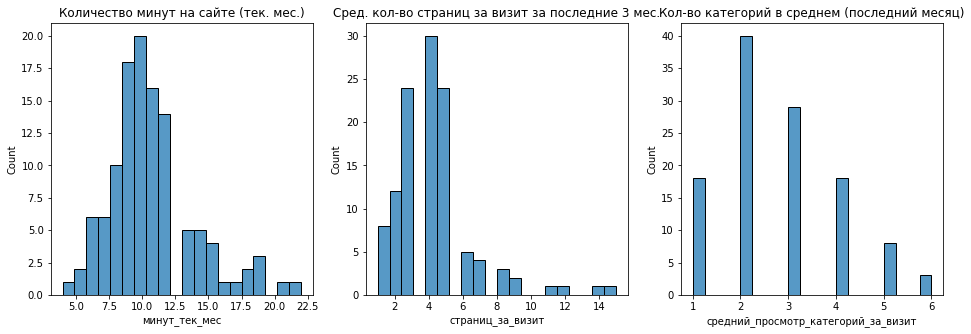

In [ ]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1, 3, 1)
sns.histplot(segmentation_class_1['минут_тек_мес'], bins=20)
plt.title(f'Количество минут на сайте (тек. мес.)')

ax = fig.add_subplot(1, 3, 2)
sns.histplot(segmentation_class_1['страниц_за_визит'], bins=20)
plt.title(f'Сред. кол-во страниц за визит за последние 3 мес.')

ax = fig.add_subplot(1, 3, 3)
sns.histplot(segmentation_class_1['средний_просмотр_категорий_за_визит'], bins=20)
plt.title(f'Кол-во категорий в среднем (последний месяц)')

pass

То же для тех, у которых высокая вероятность сохранения прежней покупательской активности:

In [ ]:
segmentation_class_2 = segmentation.query('predictions < 0.5')

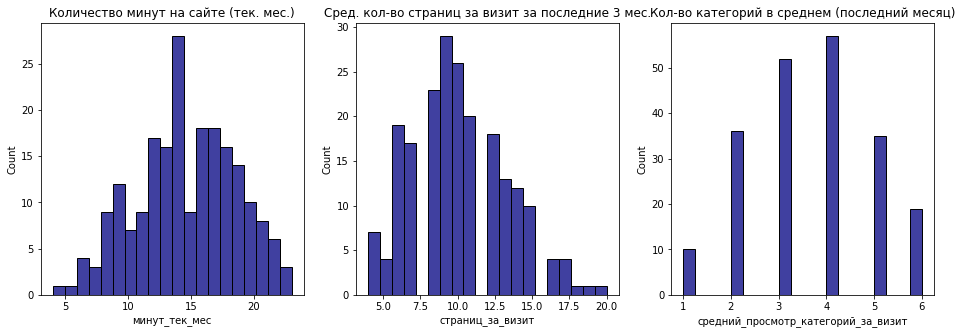

In [ ]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1, 3, 1)
sns.histplot(segmentation_class_2['минут_тек_мес'], color='navy', bins=20)
plt.title(f'Количество минут на сайте (тек. мес.)')

ax = fig.add_subplot(1, 3, 2)
sns.histplot(segmentation_class_2['страниц_за_визит'], color='navy', bins=20)
plt.title(f'Сред. кол-во страниц за визит за последние 3 мес.')

ax = fig.add_subplot(1, 3, 3)
sns.histplot(segmentation_class_2['средний_просмотр_категорий_за_визит'], color='navy', bins=20)
plt.title(f'Кол-во категорий в среднем (последний месяц)')

pass

У тех, чья покупательская активность не изменилась, бОльшая активность на сайте: в среднем больше проведенных на сайте минут,  просмотренных страниц за визит и просмотренных категорий. <br>

Также посмотрим на распределение товаров по категориям:

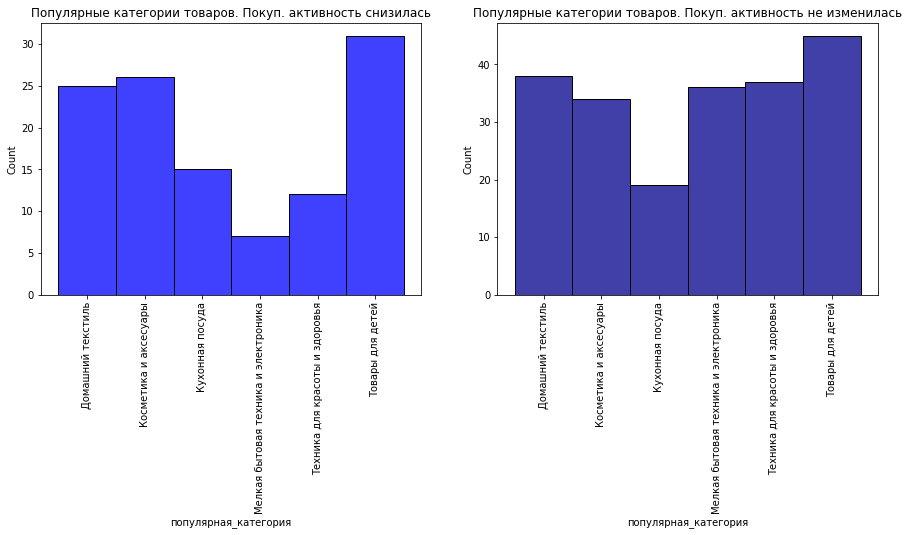

In [ ]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1, 2, 1)
g = sns.histplot(segmentation_class_1['популярная_категория'].sort_values(), color='blue', bins=20)
plt.title(f'Популярные категории товаров. Покуп. активность снизилась')
plt.xticks(rotation=90)

ax = fig.add_subplot(1, 2, 2)
g = sns.histplot(segmentation_class_2['популярная_категория'].sort_values(), color='darkblue', bins=20)
plt.title(f'Популярные категории товаров. Покуп. активность не изменилась')
plt.xticks(rotation=90)

pass

Класс 1 (покупательская активность снизилась): сильно меньше категория 'Мелкая бытовая техника и электрика', чем у класса 0 (покупательская активность не изменилась). Может быть это указывает на снижение покупательской способноси данной группы в целом? <br>
При этом, обе группы не экономят на детях. Можно таргетировать эту категорию: предлагать данные товары активнее, в т.ч. акционные.

Посмотрим на распределение прибыли:

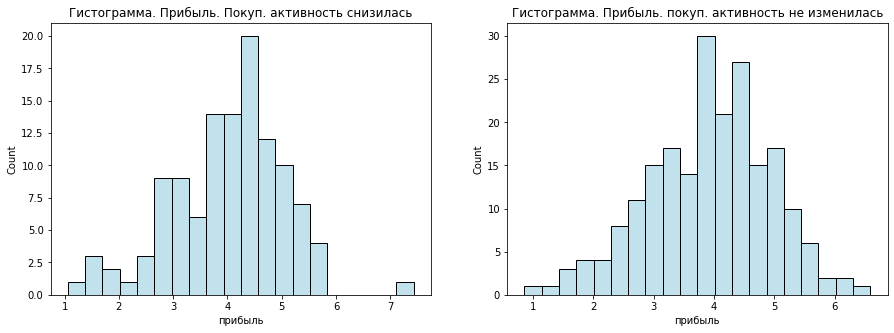

In [ ]:
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1, 2, 1)
g = sns.histplot(segmentation_class_1['прибыль'].sort_values(), color='lightblue', bins=20)
plt.title(f'Гистограмма. Прибыль. Покуп. активность снизилась')

ax = fig.add_subplot(1, 2, 2)
g = sns.histplot(segmentation_class_2['прибыль'].sort_values(), color='lightblue', bins=20)
plt.title(f'Гистограмма. Прибыль. покуп. активность не изменилась')

pass

Распределение прибыли не иделано, но похоже на нормальное. При этом наиболее часто встречающееся значение среднемесячной прибыли находится в районе 4.

### Вариант 2

Проведем еще одну сегментацию пользователей. Для этого выделим:
1. пользователей с высокой вероятностью снижения покупательской способности и наиболее высокой прибыльностью. Рассмотрев еще раз гистограмму распределения признака 'прибыль', которая была построена на этапе исследовательского анализа, возьмем прибыль со значениями > 4.5 (бОльшие значения отсекают слишком много клиентов);
2. пользователей с высокой вероятностью того, что покупательская активность сохранится прежней и наиболее высокой прибыльностью. Диапазон прибыли аналогичен п.1.

Также сдвинем порог вероятности и отсеем пользователей, которые находятся в 'пограничном состоянии' отнесения моделью к той или иной категории.

In [ ]:
segmentation_class_1_var2 = segmentation.query('predictions > 0.8 and прибыль > 4.5')
display(segmentation_class_1_var2.head())

segmentation_class_2_var2 = segmentation.query('predictions < 0.2 and прибыль > 4.5')
display(segmentation_class_2_var2.head())

,id,index,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,...,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред_мес,препредыдущий_месяц,выручка_тек_мес,минут_пред_мес,минут_тек_мес,predictions,прибыль
4,215500,152,Снизилась,стандарт,да,3.5,4,573,0.40,Косметика и аксесуары,...,4,1,4,4137.0,4278.0,3808.1,11,12,0.881890,4.99
8,215356,8,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксесуары,...,2,1,3,4146.5,4433.0,4566.4,6,7,0.945205,4.93
26,216252,904,Прежний уровень,премиум,да,4.3,3,1036,0.17,Товары для детей,...,2,2,4,3962.0,4536.0,4589.9,11,16,0.945205,5.52
27,215589,241,Снизилась,стандарт,да,4.8,5,574,0.27,Косметика и аксесуары,...,0,8,5,5372.0,4871.0,6363.9,8,4,0.945205,4.64
29,215948,600,Прежний уровень,стандарт,да,5.5,4,829,0.18,Товары для детей,...,0,5,5,3992.0,4962.0,4963.1,12,12,0.945205,4.60


,id,index,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,...,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_пред_мес,препредыдущий_месяц,выручка_тек_мес,минут_пред_мес,минут_тек_мес,predictions,прибыль
6,216533,1185,Прежний уровень,стандарт,нет,5.7,5,769,0.14,Техника для красоты и здоровья,...,1,8,10,5868.0,4925.0,5180.3,15,20,0.170732,6.59
23,216238,890,Прежний уровень,стандарт,да,4.0,4,693,0.27,Кухонная посуда,...,0,5,4,5042.5,4894.0,5301.2,18,16,0.100000,4.62
30,216453,1105,Прежний уровень,стандарт,да,4.1,5,449,0.25,Товары для детей,...,4,3,13,4037.0,4466.0,4538.8,18,15,0.170732,4.64
31,216505,1157,Прежний уровень,стандарт,нет,5.9,4,617,0.16,Мелкая бытовая техника и электроника,...,3,5,10,5998.5,5595.0,6478.2,21,18,0.170732,5.08
42,216317,969,Прежний уровень,стандарт,да,3.9,4,465,0.20,Мелкая бытовая техника и электроника,...,0,5,6,5220.0,4812.0,5703.6,16,17,0.170732,5.15


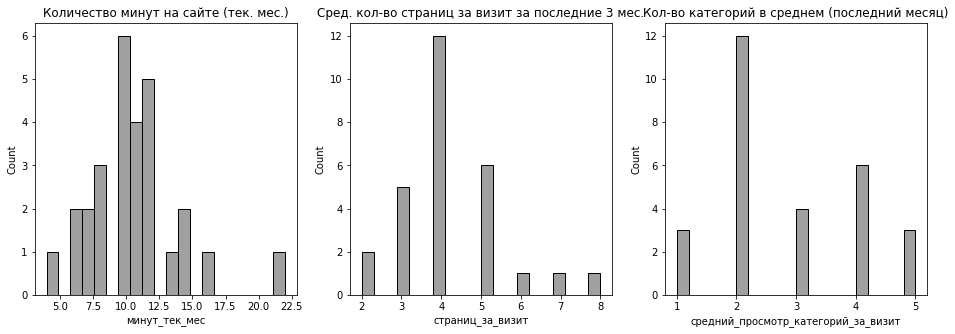

In [ ]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1, 3, 1)
sns.histplot(segmentation_class_1_var2['минут_тек_мес'], color='grey', bins=20)
plt.title(f'Количество минут на сайте (тек. мес.)')

ax = fig.add_subplot(1, 3, 2)
sns.histplot(segmentation_class_1_var2['страниц_за_визит'], color='grey', bins=20)
plt.title(f'Сред. кол-во страниц за визит за последние 3 мес.')

ax = fig.add_subplot(1, 3, 3)
sns.histplot(segmentation_class_1_var2['средний_просмотр_категорий_за_визит'], color='grey', bins=20)
plt.title(f'Кол-во категорий в среднем (последний месяц)')

pass

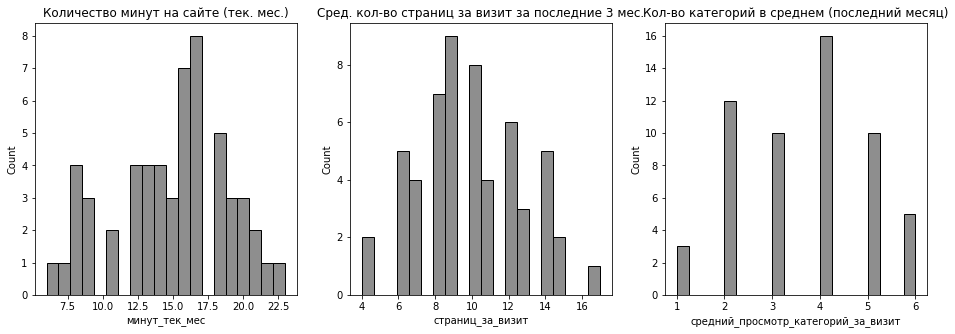

In [ ]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1, 3, 1)
sns.histplot(segmentation_class_2_var2['минут_тек_мес'], color='dimgrey', bins=20)
plt.title(f'Количество минут на сайте (тек. мес.)')

ax = fig.add_subplot(1, 3, 2)
sns.histplot(segmentation_class_2_var2['страниц_за_визит'], color='dimgrey', bins=20)
plt.title(f'Сред. кол-во страниц за визит за последние 3 мес.')

ax = fig.add_subplot(1, 3, 3)
sns.histplot(segmentation_class_2_var2['средний_просмотр_категорий_за_визит'], color='dimgrey', bins=20)
plt.title(f'Кол-во категорий в среднем (последний месяц)')

pass

Выборка из валидационных данных мала, но 'богатые' клиенты в высокой вероятностью остаться на пренем уровне активности:
проводят больше времени на сайте, просматривают больше страниц за 1 визит и смотрят больше категорий.

### Динамика выручки по месяцам

Распределение выручки по месяцам:

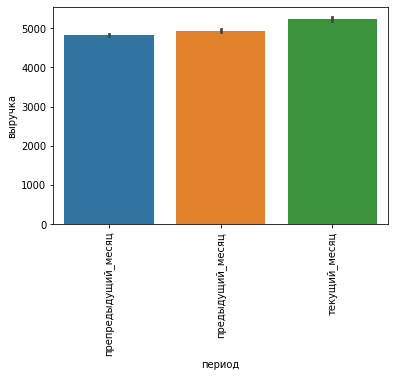

In [ ]:
sns.barplot(
    x=market_money['период'],
    y=market_money['выручка'],
    order=['препредыдущий_месяц', 'предыдущий_месяц', 'текущий_месяц']
)
plt.xticks(rotation=90)

pass

Распределение выручки по месяцам с учетом категорий товаров:

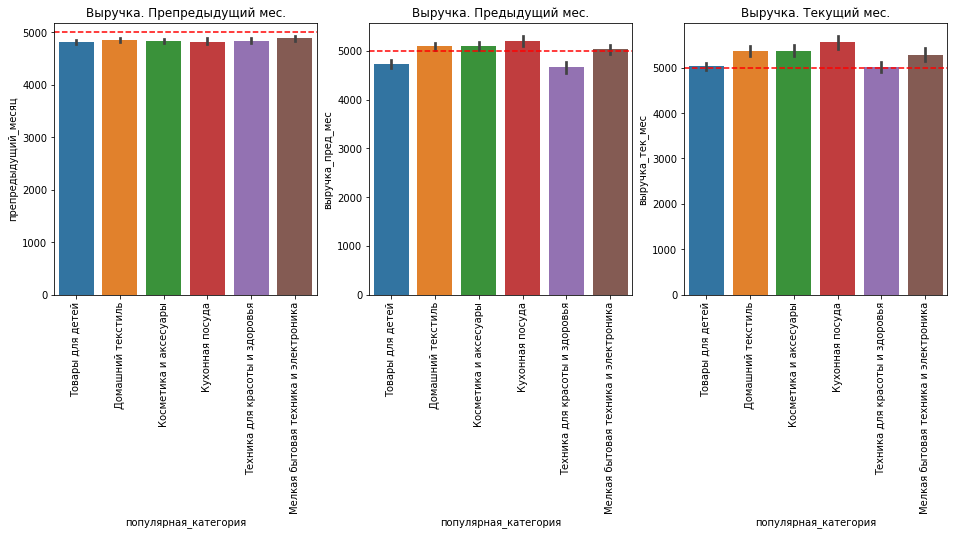

In [ ]:
fig = plt.figure(figsize=(16,5))

ax = fig.add_subplot(1, 3, 1)
sns.barplot(x=market_file_all['популярная_категория'], y=market_file_all['препредыдущий_месяц'])
plt.xticks(rotation=90)
plt.title(f'Выручка. Препредыдущий мес.')
plt.axhline (y=5000, color='red', linestyle='--')

ax = fig.add_subplot(1, 3, 2)
sns.barplot(x=market_file_all['популярная_категория'], y=market_file_all['выручка_пред_мес'])
plt.xticks(rotation=90)
plt.title(f'Выручка. Предыдущий мес.')
plt.axhline (y=5000, color='red', linestyle='--')

ax = fig.add_subplot(1, 3, 3)
sns.barplot(x=market_file_all['популярная_категория'], y=market_file_all['выручка_тек_мес'])
plt.xticks(rotation=90)
plt.title(f'Выручка. Текущий мес.')
plt.axhline (y=5000, color='red', linestyle='--')

pass

По графикам выше видно, что в целом по месяцам выручка росла, однако 'товары для детей' и 'техника для красоты и здоровья' отстали от других категорий в предыдущем месяце и в текущем месяце. 'Кухонная посуда' - в лидерах.

### Выводы

В данном разделе для исследования были выделены категории на основании ранее произведенного моделирования, а также данные о прибыльности покупателей.<br>
Были рассмотрены покупатели, разделенные по классам: класс 1 (покупательская активность снизилась), класс 0 (покупательская способность не изменилась).

Стоит подольше задерживать пользователей на сайте: время просмотра, просмотры страниц за визит, просмотры категорий сильнее всего влияют на лояльность клиентов.

Нужно определить причины проседания двух категорий ('товары для детей' и 'техника для красоты и здоровья') по выручке в динамике по месяцам, по возможности их 'подтянуть', при этом не снижая роста категорий-лидеров (лидер - 'кухонная посуда').

## Общий вывод

**Целью** настоящей работы являлось построение модели, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца. Используя данные модели и данные о прибыльности клиентов, нужно было выделить сегменты покупателей и разработать для них персонализированные предложения.

**Исходные данные** содержат несколько таблиц с различными признаками. На этапе загрузки данных они были изучены. Потверждено их соответствие описанию в задании, выделен целевой признак.<br>
Проведена **предобработка данных**, во время которой выявлены и удалены явные и неявные дубликаты.

Перед поиском **лучшей модели** был проведен исследовательский анализ данных. Рассмотрены количественные и качественные признаки, выявлены выбросы и аномальное значение.
Корреляционный анализ показал взаимосвязи входных признаков между собой. Мультиколлинеарность не выявлена.

На следующем этапе с целью автоматизации процесса поиска лучшей модели с лучшими гиперпараметрами были созданы пайплайны.

В результате моделирования на тренировочных и тестовых данных была определена **лучшая модель** со следующими гиперпараметрами: <br>
DecisionTreeClassifier(max_depth=4, max_features=3, random_state=42)

**Выводы и предложения для сегментов покупателей**:
Были рассмотрены покупатели, разделенные по классам: класс 1 (покупательская активность снизилась), класс 0 (покупательская способность не изменилась). Учитывалась также их покупательская способность.

Стоит подольше задерживать пользователей на сайте: время просмотра, просмотры страниц за визит, просмотры категорий сильнее всего влияют на лояльность клиентов.


Нужно определить причины проседания двух категорий ('товары для детей' и 'техника для красоты и здоровья') по выручке в динамике по месяцам, по возможности их 'подтянуть', при этом не снижая роста категорий-лидеров (лидер - 'кухонная посуда').


У сегмента клиентов с высокой вероятностью отнесения к классу 1 (покупательская активность снизилась) и с высокой вероятностью отнесения к классу 2 (покупательская активность осталась прежней) высокое число покупок товаров для детей.
Можно также таргетировать эту категорию: предлагать данные товары активнее, в т.ч. акционные.
